In [2]:
!export PYTHONPATH=PYTONPATH:/opt/project/sandbox_1

In [3]:
import tensorflow as tf
from model import YoloV1
from config import dict2namedtuple
from yolo_config import CFG
import numpy as np

from data_load.data_loader import DataLoader
from data import YoloData

In [4]:
import cv2
import matplotlib.pyplot as plt

In [5]:
def draw_predicted_bbox(preds, imgs):
    for img, pred in zip(imgs, preds):
        img = np.array(img, dtype=np.int32)
        pred = np.array(pred, dtype=np.float32)

        h, w = img.shape[:2]
        S = pred.shape[0]

        for y in range(S):
            for x in range(S):
                data = pred[y, x]
                if data[4] > data[9]:
                    cx, cy, bw, bh = data[:4]
                    C = data[4]
                    color = (255, 0, 0)
                else:
                    cx, cy, bw, bh = data[5:9]
                    C = data[9]
                    color = (0, 255, 0)

                bw, bh = bw**2, bh**2
                cx = int((cx+x)/S * w)
                cy = int((cy+y)/S * h)
                bw = int(bw*w)
                bh = int(bh*h)

                if C > .5:
                    img = cv2.rectangle(img,
                                        (cx-bw//2, cy-bh//2), (cx+bw//2, cy+bh//2),
                                        color, int(5*C))

        plt.imshow(img)
        plt.show()

In [6]:
def yolo_nms(pred):
    # pred : (S, S, 30)
    pred_cls = pred[..., -20:].reshape(-1, 20)  # (S*S, 20)
    pred_bndbox = pred[..., :-20].reshape(-1, 5)  # (S*S*2, 5)
    confs = pred_cls[..., np.newaxis, :] * pred_bndbox.reshape(-1, 2, 5)[..., -1, np.newaxis]  # (S*S, 2, 20)
    confs = conf.reshape(-1, 20)  # (S*S*2, 20)
    
    for cls_no, cls_confs in confs.T:  # confs.T : (20, S*S*2) / cls_confs : (S*S*2)
        sorted_confs_idx = np.argsort(cls_confs)[::-1]
        for i in range(len(sorted_confs_idx)-1):
            max_conf_idx = sorted_confs_idx[i]
            if not cls_confs[max_conf_idx]:
                continue
            for j in range(i+1, len(sorted_confs_idx)):
                conf = cls_confs[j]
                if not conf:
                    continue
                if iou(pred_bndbox[max_conf_idx], pred_bndbox[sorted_confs_idx[j]]) >= .5:
                    confs[sorted_confs_idx[j], cls_no] = 0.
    
    return np.concatenate([pred_bndbox, confs])

In [7]:
params = dict2namedtuple(CFG)

In [8]:
model = YoloV1(params)

In [21]:
model.load_weights('model_save/yolo_v1_236000')

In [22]:
dog = cv2.imread('dog.jpg')[..., ::-1]
person = cv2.imread('person.jpeg')[..., ::-1]
imgs = np.stack([cv2.resize(dog, (448, 448)), cv2.resize(person, (448, 448))], axis=0).astype(np.float32)

result = model(imgs)

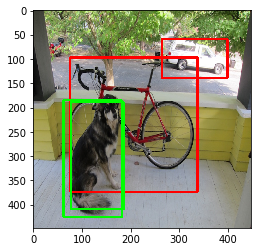

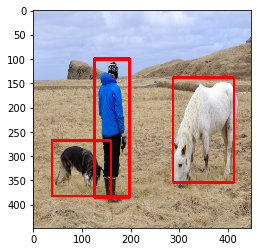

In [23]:
draw_predicted_bbox(result, imgs)